In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import time
import wandb

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# load les données

fichier = open('villes.txt')
donnees = fichier.read()
villes = donnees.replace('\n', ',').split(',')

In [4]:
# preparation des données

# on rajoute le token . au début et en fin
for ville, i in zip(villes, range(len(villes))):
    villes[i] = ville + '.'

# création du vocabulaire
vocabulaire = []

for ville in villes:
    for c in ville:
        if c not in vocabulaire:
            vocabulaire.append(c)

vocabulaire = sorted(vocabulaire)
vocabulaire[0] = '.'
vocabulaire[3] = " "

# pour convertir char <-> int
char_to_int = {}
int_to_char = {}

for (c, i) in zip(vocabulaire, range(len(vocabulaire))):
    char_to_int[c] = i
    int_to_char[i] = c

In [5]:
# création du dataset

context_len = 8

X = []
Y = []

for ville in villes:
    context = [0] * context_len

    for ch in ville:
        X.append(context)
        Y.append(char_to_int[ch])

        context = context[1:] + [char_to_int[ch]]

X = torch.tensor(X) # (M, context_len), int64
Y = torch.tensor(Y) # (M), int64

n1 = int(0.8*X.shape[0])

X_train = X[:n1]
X_val = X[n1:]

Y_train = Y[:n1]
Y_val = Y[n1:]

In [6]:
def get_batch(batch_size, split):
    if split == 'train':
        ix = torch.randint(X_train.shape[0], (batch_size,))

        if device == 'cuda':
            Xb = X_train[ix].pin_memory().to(device, non_blocking=True)
            Yb = Y_train[ix].pin_memory().to(device, non_blocking=True)
        else:
            Xb = X_train[ix].to(device)
            Yb = Y_train[ix].to(device)
    else:
        ix = torch.randint(X_val.shape[0], (batch_size,))

        if device == 'cuda':
            Xb = X_val[ix].pin_memory().to(device, non_blocking=True)
            Yb = Y_val[ix].pin_memory().to(device, non_blocking=True)
        else:
            Xb = X_val[ix].to(device)
            Yb = Y_val[ix].to(device)
    
    return Xb, Yb

In [7]:
lr = 10**(-3.901)
batch_size = 1024
embed_dim = 32
hidden_dim = 500

eval_interval = 500
eval_iter = 50

In [8]:
class BengioLM(nn.Module):
    def __init__(self):
        super().__init__()

        self.embed = nn.Embedding(len(vocabulaire), embed_dim)
        self.fc1 = nn.Linear(context_len * embed_dim, hidden_dim)

        self.lm_head = nn.Linear(hidden_dim, len(vocabulaire))

    def forward(self, x):
        x = self.embed(x).view(-1, context_len*embed_dim)

        z1 = self.fc1(x)
        a1 = F.tanh(z1)

        logits = self.lm_head(a1)

        return logits
    
    def sample(self, prompt='', max_new_tokens=None):
        prompt = context_len * '.' + prompt
        init_len = len(prompt)

        while True:
            context = prompt[-context_len:]
            context_tokenized = [char_to_int[c] for c in context]

            logits = self.forward(torch.tensor(context_tokenized, device=device))
            probs = F.softmax(logits, dim=1)

            next_token = torch.multinomial(probs, num_samples=1, replacement=True).item()
            next_char = int_to_char[next_token]

            if next_char == '.':
                break

            prompt += next_char

            if len(prompt)-init_len == max_new_tokens:
                break
        
        return prompt[context_len:]

In [9]:
model = BengioLM()

sum([p.numel() for p in model.parameters()])

151952

In [84]:
wandb.init(project="bengio_lm",
           config={
               "log_learning_rate": np.log10(lr),
               "batch_size": batch_size,
               "embed_dim": embed_dim,
               "hidden_dim": hidden_dim,
               "context_len": context_len
           })

loss_train,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_val,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
params_num,▁
training_throughput,▁
loss_train,1.5279
loss_val,1.62666
params_num,151952
training_throughput,704585.40058


In [9]:
model = BengioLM()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [12]:
N = 20000
start_time = time.time()

#wandb.watch(model, log="all")

for update_num in range(N):
    Xb, Yb = get_batch(batch_size, 'train')

    logits = model(Xb)

    loss = F.cross_entropy(logits, Yb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # eval : track loss (train & val), update_to_data
    if update_num % eval_interval == 0:
        to_log = {}

        with torch.no_grad():
            model.eval()
            for split in ['train', 'val']:
                loss_mean = 0
                for i in range(eval_iter):
                    Xb, Yb = get_batch(batch_size, split)
                    logits = model(Xb)

                    loss_mean += F.cross_entropy(logits, Yb).item()
                loss_mean /= eval_iter
                to_log["loss_" + split] = loss_mean
            model.train()

            scalars_dict = {}

            for name, p in model.named_parameters():
                scalars_dict[name] = (lr*p.grad.std() / p.data.std()).log10().item()
        
        #wandb.log(to_log | {"update_to_data": scalars_dict}, step=update_num)

end_time = time.time()
num_examples_processed = N * batch_size

print("training throughput = {} examples/s".format(str(num_examples_processed/(end_time-start_time))))
#wandb.log({"training_throughput": num_examples_processed/(end_time-start_time)})
#wandb.log({"params_num": sum([p.numel() for p in model.parameters()])})

training throughput = 664015.5310009143 examples/s


In [13]:
to_log

{'loss_train': 1.4038723802566528, 'loss_val': 1.6244510459899901}

In [19]:
wandb.finish()

In [26]:
for _ in range(10):
    print(model.sample())

mézérian
braucourt
le trize
nans
frayssinet
mascarquissey
frassonne
suvillace
saint-julien-d'ariagne
saint-médère


In [12]:
villes_gen = []

for _ in range(1000):
    villes_gen.append(model.sample(""))

In [13]:
lens_gen = [len(ville) for ville in villes_gen]
occurences_lens = [0] * (max(lens_gen)+1)

for ville in villes_gen:
    occurences_lens[len(ville)] += 1

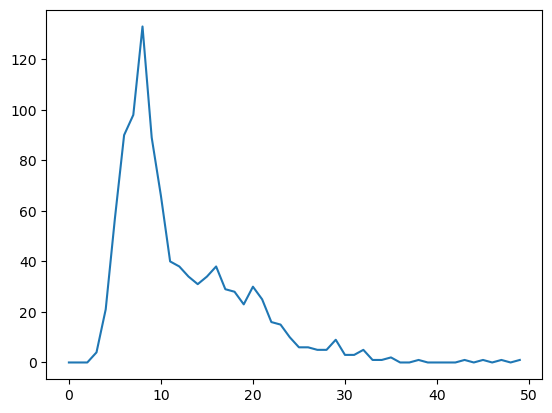

In [14]:
plt.plot(occurences_lens)

In [81]:
# batch_size    # TT    # GPU util
#  8            11,5k       32%
#  16           23k         32%
#  32           45k         32%
#  64           86k         36%
#  128          168k        40%
#  256          330k        36%
#  512          640k        38%
#  1024         1.14M       46% (optimal)
#  2048         1.5M        48%